In [56]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

import keras
import keras.layers as nn
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

import torch
from torch.utils.data import Dataset, DataLoader

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.master("local[*]").appName("Keras").getOrCreate()

In [3]:
def load_pickle(path):
    with open(path, "rb") as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        return u.load()
    
def changeFeatureFormat(total_feature):
    changed_feature = []
    datum = []
    eid = total_feature[0][0]
    for feature in total_feature:
        if eid != feature[0]:
            changed_feature.append(datum)
            datum = []
            eid = feature[0]
        datum.append(feature[1:])
    changed_feature.append(datum)
    return changed_feature

In [4]:
DATA_PATH = "/Users/beom/Workspace/DataEngineering/FinalProject/Data"

enrollment_df = (
    spark.read
        .option("header", "true")
        .option("delimiter", ",")
        .csv(DATA_PATH + "/enrollment.csv")    
        .withColumn("enrollment_id", F.col("enrollment_id").cast("int"))
)
print("enrollment_df", enrollment_df.columns)

truth_train_df = (
    spark.read
        .option("header", "true")
        .option("delimiter", ",")
        .csv(DATA_PATH + "/truth_train.csv")
        .select(
            F.col("eid").alias("enrollment_id"),
            F.col("result").cast("boolean").alias("dropout")
        )
        .withColumn("enrollment_id", F.col("enrollment_id").cast("int"))
)
print("truth_train_df", truth_train_df.columns)

truth_test_df = (
    spark.read
        .option("header", "true")
        .option("delimiter", ",")
        .csv(DATA_PATH + "/truth_test.csv")
        .select(
            F.col("eid").alias("enrollment_id"),
            F.col("result").cast("boolean").alias("dropout")
        )
        .withColumn("enrollment_id", F.col("enrollment_id").cast("int"))
)
print("truth_test_df", truth_test_df.columns)

enrollment_df ['enrollment_id', 'username', 'course_id']
truth_train_df ['enrollment_id', 'dropout']
truth_test_df ['enrollment_id', 'dropout']


In [5]:
feature1 = load_pickle(DATA_PATH + "/feature1.pkl")
feature2 = load_pickle(DATA_PATH + "/feature2.pkl")
feature3 = load_pickle(DATA_PATH + "/feature3.pkl")
feature4 = load_pickle(DATA_PATH + "/feature4.pkl")
feature5 = load_pickle(DATA_PATH + "/feature5.pkl")
feature6 = load_pickle(DATA_PATH + "/feature6.pkl")

train_feature2 = load_pickle(DATA_PATH + "/train_feature2.pkl")
train_feature3 = load_pickle(DATA_PATH + "/train_feature3.pkl")
train_feature4 = load_pickle(DATA_PATH + "/train_feature4.pkl")
train_feature5 = load_pickle(DATA_PATH + "/train_feature5.pkl")

train_enrollments = enrollment_df.join(truth_train_df, ["enrollment_id"]).collect()
test_enrollments = enrollment_df.join(truth_test_df, ["enrollment_id"]).collect()

In [6]:
class TrainDataset(Dataset):
    def __init__(self, dataset):
        self.len = len(dataset)
        self.x_data = [[r.enrollment_id, r.username, r.course_id] for r in dataset]
        self.y_data = torch.Tensor([r.dropout for r in dataset])
        
    def __getitem__(self, index):
        enrollment_id, username, course_id = self.x_data[index]
        t1 = torch.zeros(1, 30, 13)
        for t in feature1[enrollment_id]:
            t1[0][t[0]] = torch.Tensor(list(t[1]))
            
        t2 = torch.zeros(30, 10)
        for t in train_feature2[username]:
            t2[t[0]] = torch.Tensor(list(t[1]))
        t2 = t2.view(-1)
        
        t3 = torch.zeros(30, 10)
        for t in train_feature3[course_id]:
            t3[t[0]] = torch.Tensor(list(t[1]))
        t3 = t3.view(-1)
        
        t4 = torch.Tensor(list(train_feature4[username]))
        t5 = torch.Tensor(list(train_feature5[course_id]))
        t6 = torch.Tensor(list(feature6[course_id]))
            
        return t1, torch.cat([t2, t3, t4, t5, t6]), self.y_data[index]
    
    def __len__(self):
        return self.len
        
        
class TestDataset(Dataset):
    def __init__(self, dataset):
        self.len = len(dataset)
        self.x_data = [[r.enrollment_id, r.username, r.course_id] for r in dataset]
        self.y_data = torch.Tensor([r.dropout for r in dataset])
        
    def __getitem__(self, index):
        enrollment_id, username, course_id = self.x_data[index]
        t1 = torch.zeros(1, 30, 13)
        for t in feature1[enrollment_id]:
            t1[0][t[0]] = torch.Tensor(list(t[1]))
            
        t2 = torch.zeros(30, 10)
        for t in feature2[username]:
            t2[t[0]] = torch.Tensor(list(t[1]))
        t2 = t2.view(-1)
        
        t3 = torch.zeros(30, 10)
        for t in feature3[course_id]:
            t3[t[0]] = torch.Tensor(list(t[1]))
        t3 = t3.view(-1)
        
        t4 = torch.Tensor(list(feature4[username]))
        t5 = torch.Tensor(list(feature5[course_id]))
        t6 = torch.Tensor(list(feature6[course_id]))
            
        return t1, torch.cat([t2, t3, t4, t5, t6]), self.y_data[index]
    
    def __len__(self):
        return self.len
        

train_dataset = TrainDataset(train_enrollments)
test_dataset = TestDataset(test_enrollments)

batch_size = 100
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_x1 = None
train_x2 = None
train_y = None

for x1, x2, y in train_data_loader:
    if train_x1 is None: 
        train_x1 = x1
        train_x2 = x2
        train_y = y
    else:
        train_x1 = torch.cat([train_x1, x1])
        train_x2 = torch.cat([train_x2, x2])
        train_y = torch.cat([train_y, y])


test_x1 = None
test_x2 = None
test_y = None

for x1, x2, y in test_data_loader:
    if test_x1 is None: 
        test_x1 = x1
        test_x2 = x2
        test_y = y
    else:
        test_x1 = torch.cat([test_x1, x1])
        test_x2 = torch.cat([test_x2, x2])
        test_y = torch.cat([test_y, y])
        
train_x1 = train_x1.data.numpy()
train_x2 = train_x2.data.numpy()
train_y = train_y.data.numpy()

test_x1 = test_x1.data.numpy()
test_x2 = test_x2.data.numpy()
test_y = test_y.data.numpy()

In [68]:
def inception_net(x):
    h1 = nn.AveragePooling2D(pool_size=3, strides=1, padding="same", data_format="channels_first")(x)
    h1 = nn.Conv2D(filters=4, kernel_size=1, data_format="channels_first")(h1)
    h2 = nn.Conv2D(filters=3, kernel_size=1, data_format="channels_first")(x)
    h3 = nn.Conv2D(filters=3, kernel_size=1, data_format="channels_first")(x)
    h3 = nn.Conv2D(filters=6, kernel_size=5, padding="same", data_format="channels_first")(h3)
    h = nn.Concatenate(axis=1)([h1, h2, h3])
    return h

def make_model():
    input1 = nn.Input(shape=(1, 30, 13))
    input2 = nn.Input(shape=(622,))
    
    h1 = nn.Conv2D(filters=15, kernel_size=3, strides=1, data_format="channels_first")(input1)
    h1 = nn.AveragePooling2D(pool_size=2, strides=2, data_format="channels_first")(h1)
    h1 = nn.ReLU()(h1)
    h1 = inception_net(h1)
    h1 = nn.Flatten(data_format="channels_first")(h1)
    h1 = nn.Dense(512, activation="relu")(h1)
    h1 = nn.Dense(512)(h1)
    
    h2 = nn.Dense(512, activation="relu")(input2)
    h2 = nn.Dense(512)(h2)
    
    h = nn.Concatenate(axis=1)([h1, h2])
    h = nn.Dense(258, activation="relu")(h)
    h = nn.Dense(1, activation="sigmoid")(h)
    
    model = Model(inputs=[input1, input2], outputs=[h])
    return model
    
model = make_model()

MODEL_PATH = DATA_PATH + "/keras_model"

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

cb_checkpoint = ModelCheckpoint(
    MODEL_PATH + "/{epoch:02d}-{val_loss:.4f}-{val_acc:.4f}-{val_auc:.4f}.hdf5",
    verbose=1,
    monitor="val_loss",
)

In [69]:
model.load_weights(MODEL_PATH + "/08-0.3863-0.8677-0.7892.hdf5")

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(lr=1e-5),
    metrics=["acc"]
)


model.fit(
    [train_x1, train_x2], train_y, 
    validation_data=([test_x1, test_x2], test_y),
    batch_size=256, 
    shuffle=True, 
    verbose=1, 
    epochs=50, 
    initial_epoch=8,
    callbacks=[cb_checkpoint]
)

Train on 90502 samples, validate on 30040 samples
Epoch 9/50
90502/90502 [==============================] - 258s 3ms/step - loss: 0.3910 - acc: 0.8682 - auc: 0.8402 - val_loss: 0.5698 - val_acc: 0.8467 - val_auc: 0.8340

Epoch 00009: saving model to /Users/beom/Workspace/DataEngineering/FinalProject/Data/keras_model/09-0.5698-0.8467-0.8340.hdf5
Epoch 10/50
90502/90502 [==============================] - 255s 3ms/step - loss: 0.3667 - acc: 0.8710 - auc: 0.8325 - val_loss: 0.4020 - val_acc: 0.8681 - val_auc: 0.8414

Epoch 00010: saving model to /Users/beom/Workspace/DataEngineering/FinalProject/Data/keras_model/10-0.4020-0.8681-0.8414.hdf5
Epoch 11/50
90502/90502 [==============================] - 255s 3ms/step - loss: 0.3693 - acc: 0.8703 - auc: 0.8432 - val_loss: 0.7155 - val_acc: 0.8433 - val_auc: 0.8374

Epoch 00011: saving model to /Users/beom/Workspace/DataEngineering/FinalProject/Data/keras_model/11-0.7155-0.8433-0.8374.hdf5
Epoch 12/50
90502/90502 [==============================] 

KeyboardInterrupt: 

In [ ]:
def make_roc_curve(model, x1, x2, y):
    scores = model.predict([x1, x2])
    pred = scores.reshape(-1)
    true = y.reshape(-1)
    
    _pred = np.array([1 if p >= 0.5 else 0 for p in pred])
    
    fpr, tpr, thresholds = metrics.roc_curve(true, pred)
    auc = metrics.auc(fpr, tpr)
    acc = metrics.accuracy_score(true, _pred)
    diff = np.sum(np.abs(true - _pred))
    
    plt.plot(fpr, tpr)
    plt.show()
    print(auc, acc, diff)

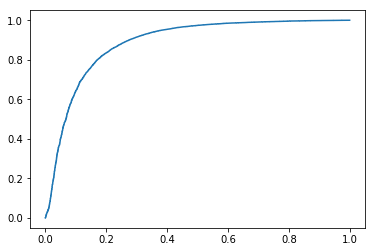

0.8854838533881986 0.8810585885486019 3573.0


In [84]:
model.load_weights(MODEL_PATH + "/22-0.3365-0.8811-0.8597.hdf5")
make_roc_curve(model, test_x1, test_x2, test_y)

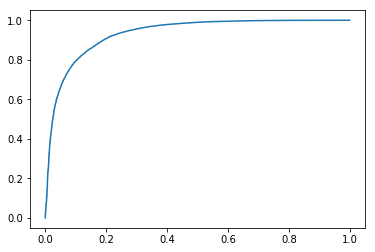

0.9321767065427619 0.9026430355130274 8811.0


In [85]:
make_roc_curve(model, train_x1, train_x2, train_y)

In [80]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from sklearn import metrics
from torch.utils.data import Dataset, DataLoader

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
    
def make_pytorch_model():
    
    class Flatten(nn.Module):
        def forward(self, x):
            N, C, H, W = x.size()
            return x.view(N, -1)


    class InceptionA(nn.Module):
        def __init__(self, in_channels):
            super(InceptionA, self).__init__()
            self.avg_pooling = torch.nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
            self.conv1 = torch.nn.Conv2d(in_channels, 4, kernel_size=1)
            self.conv2 = torch.nn.Conv2d(in_channels, 3, kernel_size=1)
            self.conv3 = torch.nn.Conv2d(in_channels, 3, kernel_size=1)
            self.conv4 = torch.nn.Conv2d(3, 6, kernel_size=5, padding=2)

        def forward(self, x):
            h1 = self.avg_pooling(x)
            h1 = self.conv1(h1)
            h2 = self.conv2(x)
            h3 = self.conv3(x)
            h3 = self.conv4(h3)
            h = torch.cat([h1, h2, h3], 1)
            return h


    class CNNModel(nn.Module):
        def __init__(self, output_size):
            super(CNNModel, self).__init__()
            self.network = nn.Sequential(
                nn.Conv2d(1, 15, kernel_size=3, stride=1),
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.ReLU(inplace=True),
                InceptionA(15),
                Flatten(),
                nn.Linear(910, output_size),
                nn.ReLU(inplace=True),
                nn.Linear(output_size, output_size),
            )

        def forward(self, x):
            return self.network(x)


    class MLPModel(nn.Module):
        def __init__(self, output_size):
            super(MLPModel, self).__init__()
            self.network = nn.Sequential(
                nn.Linear(622, output_size),
                nn.ReLU(inplace=True),
                nn.Linear(output_size, output_size),
            )

        def forward(self, x):
            return self.network(x)


    class Model(nn.Module):
        def __init__(self):
            super(Model, self).__init__()
            self.cnn_network = CNNModel(512)
            self.mlp_network = MLPModel(512)
            self.concated_network = nn.Sequential(
                nn.Linear(1024, 258),
                nn.ReLU(inplace=True),
                nn.Linear(258, 1),
                nn.Sigmoid(),
            )

        def forward(self, x):
            x1, x2 = x
            h1 = self.cnn_network(x1)
            h2 = self.mlp_network(x2)
            h = torch.cat([h1, h2], 1)
            h = self.concated_network(h)
            return h

    pytorch_model = Model()

    load_data = torch.load(DATA_PATH + "/model/epoch-67")
    pytorch_model.load_state_dict(load_data["model_state_dict"])

    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

    print(get_n_params(pytorch_model))
    return pytorch_model
    
pytorch_model = make_pytorch_model()

1576195


In [74]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

import keras
import keras.layers as nn
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

import torch
from torch.utils.data import Dataset, DataLoader

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

def make_keras_model():

    def inception_net(x):
        h1 = nn.AveragePooling2D(pool_size=3, strides=1, padding="same", data_format="channels_first")(x)
        h1 = nn.Conv2D(filters=4, kernel_size=1, data_format="channels_first", name="cnn_network.network.3.conv1")(h1)
        h2 = nn.Conv2D(filters=3, kernel_size=1, data_format="channels_first", name="cnn_network.network.3.conv2")(x)
        h3 = nn.Conv2D(filters=3, kernel_size=1, data_format="channels_first", name="cnn_network.network.3.conv3")(x)
        h3 = nn.Conv2D(filters=6, kernel_size=5, padding="same", data_format="channels_first", name="cnn_network.network.3.conv4")(h3)
        h = nn.Concatenate(axis=1)([h1, h2, h3])
        return h

    def make_model():
        input1 = nn.Input(shape=(1, 30, 13))
        input2 = nn.Input(shape=(622,))

        h1 = nn.Conv2D(filters=15, kernel_size=3, strides=1, data_format="channels_first", name="cnn_network.network.0")(input1)
        h1 = nn.AveragePooling2D(pool_size=2, strides=2, data_format="channels_first")(h1)
        h1 = nn.ReLU()(h1)
        h1 = inception_net(h1)
        h1 = nn.Flatten(data_format="channels_first")(h1)
        h1 = nn.Dense(512, activation="relu", name="cnn_network.network.5")(h1)
        h1 = nn.Dense(512, name="cnn_network.network.7")(h1)

        h2 = nn.Dense(512, activation="relu", name="mlp_network.network.0")(input2)
        h2 = nn.Dense(512, name="mlp_network.network.2")(h2)

        h = nn.Concatenate(axis=1)([h1, h2])
        h = nn.Dense(258, activation="relu", name="concated_network.0")(h)
        h = nn.Dense(1, activation="sigmoid", name="concated_network.2")(h)

        model = Model(inputs=[input1, input2], outputs=[h])
        return model

    keras_model = make_model()
    keras_model.summary()
    return keras_model

model = make_keras_model()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           (None, 1, 30, 13)    0                                            
__________________________________________________________________________________________________
cnn_network.network.0 (Conv2D)  (None, 15, 28, 11)   150         input_81[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_65 (AveragePo (None, 15, 14, 5)    0           cnn_network.network.0[0][0]      
__________________________________________________________________________________________________
re_lu_10 (ReLU)                 (None, 15, 14, 5)    0           average_pooling2d_65[0][0]       
__________________________________________________________________________________________________
average_po

In [76]:
from __future__ import print_function
from collections import OrderedDict

import numpy as np
import h5py
import keras
import torch

VAR_AFFIX = ':0' if keras.backend.backend() == 'tensorflow' else ''

KERAS_GAMMA_KEY = 'gamma' + VAR_AFFIX
KERAS_KERNEL_KEY = 'kernel' + VAR_AFFIX
KERAS_ALPHA_KEY = 'alpha' + VAR_AFFIX
KERAS_BIAS_KEY = 'bias' + VAR_AFFIX
KERAS_BETA_KEY = 'beta' + VAR_AFFIX
KERAS_MOVING_MEAN_KEY = 'moving_mean' + VAR_AFFIX
KERAS_MOVING_VARIANCE_KEY = 'moving_variance' + VAR_AFFIX
KERAS_EPSILON = 1e-3
PYTORCH_EPSILON = 1e-5


_WEIGHT_KEYS = ['kernel', 'beta', 'alpha']
_WEIGHT_KEYS += [key+':0' for key in _WEIGHT_KEYS]


def state_dict_layer_names(state_dict):
    layer_names = [".".join(k.split('.')[:-1]) for k in state_dict.keys()]
    return list(OrderedDict.fromkeys(layer_names))


def _contains_weights(keras_h5_layer):
    for key in _WEIGHT_KEYS:
        if key in keras_h5_layer:
            return True
    return False


def dig_to_params(keras_h5_layer):
    while not _contains_weights(keras_h5_layer):
        keras_h5_layer = keras_h5_layer[list(keras_h5_layer.keys())[0]]

    return keras_h5_layer

def check_for_missing_layers(keras_names, pytorch_layer_names, verbose):

    if verbose:
        print("Layer names in PyTorch state_dict", pytorch_layer_names)
        print("Layer names in Keras HDF5", keras_names)

    if not all(x in keras_names for x in pytorch_layer_names):
        missing_layers = list(set(pytorch_layer_names) - set(keras_names))
        raise Exception("Missing layer(s) in Keras HDF5 that are present" +
                        " in state_dict: {}".format(missing_layers))


def keras_to_pytorch(keras_model, pytorch_model,
                     flip_filters=None, verbose=True):

    # If not specifically set, determine whether to flip filters automatically
    # for the right backend.
    if flip_filters is None:
        flip_filters = not keras.backend.backend() == 'tensorflow'

    keras_model.save('temp.h5')
    input_state_dict = pytorch_model.state_dict()
    pytorch_layer_names = state_dict_layer_names(input_state_dict)

    with h5py.File('temp.h5', 'r') as f:
        model_weights = f['model_weights']
        layer_names = list(map(str, model_weights.keys()))
        check_for_missing_layers(layer_names, pytorch_layer_names, verbose)
        state_dict = OrderedDict()

        for layer in pytorch_layer_names:

            params = dig_to_params(model_weights[layer])

            weight_key = layer + '.weight'
            bias_key = layer + '.bias'
            running_mean_key = layer + '.running_mean'
            running_var_key = layer + '.running_var'

            # Load weights (or other learned parameters)
            if weight_key in input_state_dict:
                if KERAS_GAMMA_KEY in params:
                    weights = params[KERAS_GAMMA_KEY][:]
                elif KERAS_KERNEL_KEY in params:
                    weights = params[KERAS_KERNEL_KEY][:]
                else:
                    weights = np.squeeze(params[KERAS_ALPHA_KEY][:])

                weights = convert_weights(weights,
                                          to_keras=True,
                                          flip_filters=flip_filters)

                state_dict[weight_key] = torch.from_numpy(weights)

            # Load bias
            if bias_key in input_state_dict:
                if running_var_key in input_state_dict:
                    bias = params[KERAS_BETA_KEY][:]
                else:
                    bias = params[KERAS_BIAS_KEY][:]
                state_dict[bias_key] = torch.from_numpy(
                    bias.transpose())

            # Load batch normalization running mean
            if running_mean_key in input_state_dict:
                running_mean = params[KERAS_MOVING_MEAN_KEY][:]
                state_dict[running_mean_key] = torch.from_numpy(
                    running_mean.transpose())

            # Load batch normalization running variance
            if running_var_key in input_state_dict:
                running_var = params[KERAS_MOVING_VARIANCE_KEY][:]
                # account for difference in epsilon used
                running_var += KERAS_EPSILON - PYTORCH_EPSILON
                state_dict[running_var_key] = torch.from_numpy(
                    running_var.transpose())

    pytorch_model.load_state_dict(state_dict)


def pytorch_to_keras(pytorch_model, keras_model,
                     flip_filters=False, flip_channels=None, verbose=True):

    if flip_channels is None:
        flip_channels = not keras.backend.backend() == 'tensorflow'

    keras_model.save('temp.h5')
    input_state_dict = pytorch_model.state_dict()
    pytorch_layer_names = state_dict_layer_names(input_state_dict)

    with h5py.File('temp.h5', 'a') as f:
        model_weights = f['model_weights']
        target_layer_names = list(map(str, model_weights.keys()))
        check_for_missing_layers(
            target_layer_names,
            pytorch_layer_names,
            verbose)

        for layer in pytorch_layer_names:

            params = dig_to_params(model_weights[layer])

            weight_key = layer + '.weight'
            bias_key = layer + '.bias'
            running_mean_key = layer + '.running_mean'
            running_var_key = layer + '.running_var'

            # Load weights (or other learned parameters)
            if weight_key in input_state_dict:
                weights = input_state_dict[weight_key].numpy()
                weights = convert_weights(weights,
                                          to_keras=False,
                                          flip_filters=flip_filters,
                                          flip_channels=flip_channels)

                if KERAS_GAMMA_KEY in params:
                    params[KERAS_GAMMA_KEY][:] = weights
                elif KERAS_KERNEL_KEY in params:
                    params[KERAS_KERNEL_KEY][:] = weights
                else:
                    weights = weights.reshape(params[KERAS_ALPHA_KEY][:].shape)
                    params[KERAS_ALPHA_KEY][:] = weights

            # Load bias
            if bias_key in input_state_dict:
                bias = input_state_dict[bias_key].numpy()
                if running_var_key in input_state_dict:
                    params[KERAS_BETA_KEY][:] = bias
                else:
                    params[KERAS_BIAS_KEY][:] = bias

            # Load batch normalization running mean
            if running_mean_key in input_state_dict:
                running_mean = input_state_dict[running_mean_key].numpy()
                params[KERAS_MOVING_MEAN_KEY][:] = running_mean

            # Load batch normalization running variance
            if running_var_key in input_state_dict:
                running_var = input_state_dict[running_var_key].numpy()
                # account for difference in epsilon used
                running_var += PYTORCH_EPSILON - KERAS_EPSILON
                params[KERAS_MOVING_VARIANCE_KEY][:] = running_var

    # pytorch_model.load_state_dict(state_dict)
    keras_model.load_weights('temp.h5')


def convert_weights(weights, to_keras, flip_filters, flip_channels=False):

    if len(weights.shape) == 3:  # 1D conv
        weights = weights.transpose()

        if flip_channels:
            weights = weights[::-1]

        if flip_filters:
            weights = weights[..., ::-1].copy()

    if len(weights.shape) == 4:  # 2D conv
        if to_keras:  # D1 D2 F F
            weights = weights.transpose(3, 2, 0, 1)
        else:
            weights = weights.transpose(2, 3, 1, 0)

        if flip_channels:
            weights = weights[::-1, ::-1]
        if flip_filters:
            weights = weights[..., ::-1, ::-1].copy()

    elif len(weights.shape) == 5:  # 3D conv
        if to_keras:  # D1 D2 D3 F F
            weights = weights.transpose(4, 3, 0, 1, 2)
        else:
            weights = weights.transpose(2, 3, 4, 1, 0)

        if flip_channels:
            weights = weights[::-1, ::-1, ::-1]

        if flip_filters:
            weights = weights[..., ::-1, ::-1, ::-1].copy()
    else:
        weights = weights.transpose()

    return weights

In [81]:
pytorch_to_keras(pytorch_model, model)

Layer names in PyTorch state_dict ['cnn_network.network.0', 'cnn_network.network.3.conv1', 'cnn_network.network.3.conv2', 'cnn_network.network.3.conv3', 'cnn_network.network.3.conv4', 'cnn_network.network.5', 'cnn_network.network.7', 'mlp_network.network.0', 'mlp_network.network.2', 'concated_network.0', 'concated_network.2']
Layer names in Keras HDF5 ['average_pooling2d_65', 'average_pooling2d_66', 'cnn_network.network.0', 'cnn_network.network.3.conv1', 'cnn_network.network.3.conv2', 'cnn_network.network.3.conv3', 'cnn_network.network.3.conv4', 'cnn_network.network.5', 'cnn_network.network.7', 'concated_network.0', 'concated_network.2', 'concatenate_52', 'concatenate_53', 'flatten_20', 'input_81', 'input_82', 'mlp_network.network.0', 'mlp_network.network.2', 're_lu_10']
